In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(42)



import pandas as pd
import numpy as np

/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_7502/371641541.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# SUGGESTED BVP:
# y'' = -2 , y(0) = y(1) = 1
"""
a = 0
b = 1
y_a = 1
y_b = 1

def ode_function(x, y):
    return -2

def analytical_solution(x):
    return 1 + (x * (1 - x))

"""
# ANOTHER BVP:
# y'' = 9 * y, y(0) = 0, y(1) = 6
a = 0
b = 1
y_a = 0
y_b = 6
def ode_function(x, y):
    return 9 * y

def analytical_solution(x):
    return (6 * np.exp(3 - 3 * x) * (-1 + np.exp(6 * x)))/ (-1 + np.exp(6))


# Define the ANN model
model = torch.nn.Sequential(
    torch.nn.Linear(1, 5),
    torch.nn.Sigmoid(),
    torch.nn.Linear(5, 1)
)

# Interesting part with the analytical derivatives (backpropagation-style) is in the cell below!

In [3]:
# Training loop
import time
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

for epoch in range(1000):
    optimizer.zero_grad()
    
    # Sample x within the domain
    #x = torch.rand(10, 1) * (b - a) + a  # Assume a and b are defined
    x = torch.linspace(a, b, 4).unsqueeze(1)  # Unsqueeze to make it a column vector
    x.requires_grad_(True)  # Enable gradient computation for x
    
    # Compute y and its derivatives
    y = model(x)
    y.requires_grad_(True)
    start = time.process_time()
    y_prime = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    start = time.process_time()
    y_double_prime = torch.autograd.grad(y_prime, x, torch.ones_like(y_prime), create_graph=True)[0]
    
    # Compute the loss
    loss_ode = torch.mean((y_double_prime - ode_function(x, y))**2)
    loss_bc = (model(torch.tensor([[a]], dtype=torch.float32)) - y_a)**2 + (model(torch.tensor([[b]], dtype=torch.float32)) - y_b)**2
    loss = loss_ode + loss_bc
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 53.69953918457031
Epoch 100, Loss: 34.9398078918457
Epoch 200, Loss: 34.74423599243164
Epoch 300, Loss: 33.9184684753418
Epoch 400, Loss: 14.043695449829102
Epoch 500, Loss: 0.29818764328956604
Epoch 600, Loss: 0.048777710646390915
Epoch 700, Loss: 0.035685840994119644
Epoch 800, Loss: 0.02562844194471836
Epoch 900, Loss: 0.007474593818187714


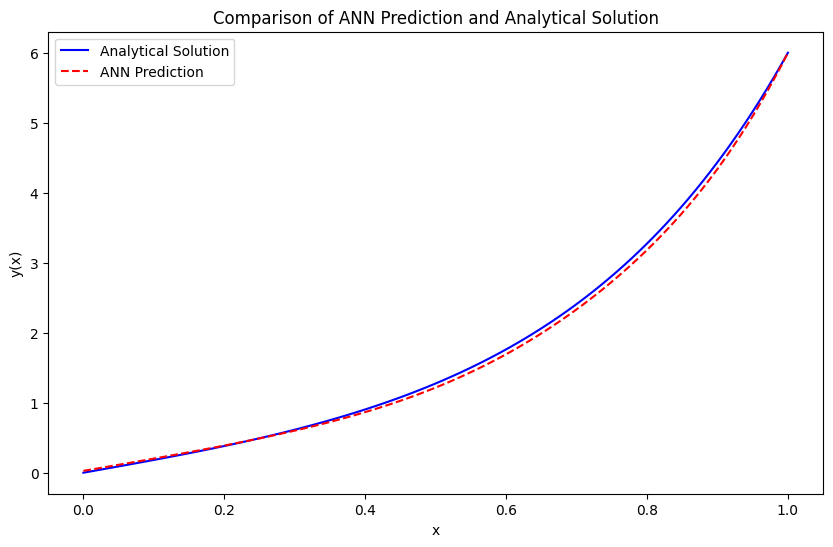

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Sampling x values
x_values = np.linspace(a, b, 100)
x_tensor = torch.tensor(x_values.reshape(-1, 1), dtype=torch.float32)

# Use the trained model for predictions (make sure it's already loaded and trained)
with torch.no_grad():  # No need for gradients here
    y_pred = model(x_tensor).numpy()

# Compute the analytical solution
y_true = analytical_solution(x_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_true, label='Analytical Solution', color='blue')
plt.plot(x_values, y_pred, label='ANN Prediction', linestyle='--', color='red')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Comparison of ANN Prediction and Analytical Solution')
plt.legend()
plt.show()
